# Water Observations using Landsat Timeseries

## Background
Geoscience Australia's Water Observations from Space (WOfS) classifier is a decision tree that transforms individual multispectral Landsat observations into a surface-water occurrence map. 

## Description
In this example, we apply the WOfS classifier to the USGS Landsat Collection 2 to map surface-water occurrence and long-term trends.

### Packages and functions
Import Python packages that are used for the analysis.

In [1]:
# turn off warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
# only importing required packages

from datacube import Datacube
from odc.geo.geom import point

#from odc.algo import mask_cleanup

# if dask is used
#import dask.config
#from dask.distributed import Client, LocalCluster

# for landsat data access
import os
from odc.stac import configure_s3_access
from piksel.utils import patch_usgs_landsat

# for wofs on landsat
import numpy as np
from wofs.classifier import classify
from wofs.constants import NO_DATA
from wofs.filters import c2_filter, eo_filter, terrain_filter
from wofs.virtualproduct import scale_and_clip_dataarray
from xarray import DataArray

# for DSM
from pystac_client import Client
from odc.stac import load
from planetary_computer import sign_url

# for bit mask
from datacube.utils.masking import make_mask

In [3]:
from collections import Counter

def mostcommon_crs(datasets):
    crs_counts = Counter(dataset.metadata_doc["crs"] for dataset in datasets)
    return crs_counts.most_common(1)[0][0]

### Configure AWS for Landsat data access

In [4]:
# Configure AWS
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

if "AWS_NO_SIGN_REQUEST" in os.environ:
    del os.environ["AWS_NO_SIGN_REQUEST"]

configure_s3_access(requester_pays=True)


## Select a study site

Keep the area small for long time series analysis

In [5]:
start_date = "2016-01"
# start with one year for testing
start_date = "2025-01"
end_date = "2025-12"

coords = -4.02, 120.02  # Lake Tempe
coords = 1.21, 109.00  # Coastal
coords = 0.66, 112.20  # Kapuas River


aoi_point = point(coords[1], coords[0], crs="EPSG:4326")
area = aoi_point.buffer(0.04).boundingbox

area.explore()

## Load satellite data

Load spectral bands and data quality measurements relevant for WOfS.

In [6]:
dc = Datacube()

In [7]:
# bands have to be supplied in order
wofs_bands = ["blue", "green", "red", "nir08", "swir16", "swir22"]

In [8]:
# define sensor and resolution
product = ["ls5_c2l2_sr", "ls7_c2l2_sr", "ls8_c2l2_sr", "ls9_c2l2_sr"]
resolution = 30
qa_band = "qa_pixel"

In [9]:
# Find datasets
datasets = dc.find_datasets(
    product=product,
    time=(start_date, end_date),
    longitude=(area.left, area.right),
    latitude=(area.bottom, area.top),
    # only use high-quality imagery for testing
    landsat_collection_category='T1',
    cloud_cover = (0, 60),
)

crs = mostcommon_crs(datasets)

print(f"Found {len(datasets)} datasets")
print(f"Most common CRS is {crs}")

data = dc.load(
    datasets=datasets,
    longitude=(area.left, area.right),
    latitude=(area.bottom, area.top),
    resolution=resolution,
    output_crs=crs,
    measurements=wofs_bands + [qa_band],
    group_by="solar_day",
    dask_chunks={"time": 1, "x": 500, "y": 500},
    resampling={
        "*": "bilinear",
        qa_band: "nearest",
    },
    patch_url=patch_usgs_landsat,
    driver="rio",
)

Querying product Product(name='ls5_c2l2_sr', id_=17)
Querying product Product(name='ls7_c2l2_sr', id_=16)
Querying product Product(name='ls8_c2l2_sr', id_=15)
Querying product Product(name='ls9_c2l2_sr', id_=14)


Found 360 datasets
Most common CRS is EPSG:32649


In [10]:
data=data.compute()
data

<xarray.Dataset> Size: 332MB
Dimensions:      (y: 296, x: 298, time: 269)
Coordinates:
  * y            (y) float64 2kB 7.738e+04 7.736e+04 ... 6.856e+04 6.854e+04
  * x            (x) float64 2kB 6.291e+05 6.291e+05 ... 6.38e+05 6.38e+05
    spatial_ref  int32 4B 32649
  * time         (time) datetime64[ns] 2kB 2016-03-12T02:45:59.152798 ... 202...
Data variables:
    blue         (time, y, x) uint16 47MB 19185 22754 21429 ... 43919 41617
    green        (time, y, x) uint16 47MB 20700 23615 22465 ... 43418 41130
    red          (time, y, x) uint16 47MB 20292 23424 22205 ... 43726 41195
    nir08        (time, y, x) uint16 47MB 24868 27614 26604 ... 44918 42503
    swir16       (time, y, x) uint16 47MB 20168 22296 21347 ... 28361 25665
    swir22       (time, y, x) uint16 47MB 15923 17665 17096 ... 20764 18700
    qa_pixel     (time, y, x) uint16 47MB 22280 22280 22280 ... 22280 22280

## Digital Elevation Model for terrain masking

In areas with steep terrain, slope masking would be helpful, as water is unlikely to occur on steep slopes.

In [11]:
# DSM for terrain masking
mspc_catalog = "https://planetarycomputer.microsoft.com/api/stac/v1"

# Get a STAC client
client = Client.open(mspc_catalog)

# Load elevation
dem_items = list(
    client.search(
        collections=["cop-dem-glo-30"],
        intersects = data.odc.geobox.geographic_extent,
    ).items()
)

dem = load(dem_items, like=data, patch_url=sign_url).squeeze().compute()

dsm = dem.rename({"data": "elevation"})

In [12]:
#dsm.elevation.plot.imshow()

## Water classification with masking

We will use the the full suite of functions from `wofs` to classify water and mask for invalid and unreliable observations.

In [13]:
# define functions to apply for wofs

def scale_data(data, scale_factor=1, add_offset=0):
    """Apply scaling and offset"""
    attrs = data.attrs
    data =  data.apply(scale_and_clip_dataarray, keep_attrs=False,
                       scale_factor=scale_factor, add_offset=add_offset,
                       clip_range=(0, 10000), valid_range=None)
    data.attrs = attrs
    return data

def scale_data_ls(data):
    return scale_data(data, scale_factor=0.275, add_offset=-2000)
    

def ls_wofs(in_data: DataArray):
    """
    Classify Landsat observations
    """
    if 'time' in in_data.dims.keys():
        in_data = in_data.squeeze("time", drop=False)

    data_scaled = scale_data_ls(in_data[wofs_bands])

    # Run the classifier
    wofs_raw = classify(data_scaled.to_array())

    # Set up attrs on the DSM
    dsm.attrs["crs"] = in_data.odc.crs

    # Set up the masks and combine them
    no_data = in_data.red == 0

    wofs_masked = (
        wofs_raw
        | eo_filter(data_scaled)
        | terrain_filter(dsm, in_data, no_data=0, ignore_dsm_no_data=True)
        | c2_filter(in_data.qa_pixel)
        | no_data
    )

    # Messy little thing to make any nodata areas ONLY nodata
    nodata_set = np.bitwise_and(wofs_masked, NO_DATA) == NO_DATA

    # If we don't specifically set the dtype in the following line,
    # dask arrays explode to int64s. Make sure it stays a uint8!
    wofs_masked.data[nodata_set] = np.array(NO_DATA, dtype="uint8")

    return wofs_masked

In [14]:
wofs_masked = data.groupby("time").apply(ls_wofs)

## Interpreting WOfS bit masks

WOfS outputs are stored as a bit field. This is a binary number, where each digit of the number is independantly set based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, a single decimal value for each pixel can provide information about a variety of features of that pixel.

See [DEA Knowledge Hub](https://knowledge.dea.ga.gov.au/notebooks/DEA_products/DEA_Water_Observations/) for detailed explanation and more examples.

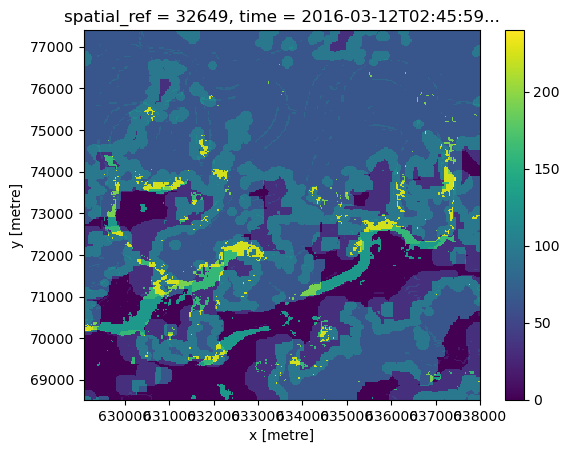

In [15]:
# example plot to show values are hard to interpret directly
wofs_masked.isel(time=0).plot.imshow();

To use ODC tools for masking, we will first define bit flags as a dictionary.

In [16]:
flags_definition = {
    "dry": {
        "bits": [7, 6, 5, 4, 3, 2, 1, 0],
        "description": "No water detected",
        "values": {0: True}
    },
    "nodata": {
        "bits": 0,
        "description": "No data",
        "values": {0: False, 1: True}
    },
    "noncontiguous": {
        "bits": 1,
        "description": "At least one EO band is missing or saturated",
        "values": {0: False, 1: True}
    },
    "low_solar_angle": {
        "bits": 2,
        "description": "Low solar incidence angle",
        "values": {0: False, 1: True}
    },
    "terrain_shadow": {
        "bits": 3,
        "description": "Terrain shadow",
        "values": {0: False, 1: True}
    },
    "high_slope": {
        "bits": 4,
        "description": "High slope",
        "values": {0: False, 1: True}
    },
    "cloud_shadow": {
        "bits": 5,
        "description": "Cloud shadow",
        "values": {0: False, 1: True}
    },
    "cloud": {
        "bits": 6,
        "description": "Cloudy",
        "values": {0: False, 1: True}
    },
    "water_observed": {
        "bits": 7,
        "description": "Classified as water by the decision tree",
        "values": {0: False, 1: True}
    },
    "wet": {
        "bits": [7, 6, 5, 4, 3, 2, 1, 0],
        "description": "Clear and Wet",
        "values": {128: True}
    }
}

wofs_masked.attrs['flags_definition'] = flags_definition

In [17]:
# wet and clear 
wet = make_mask(wofs_masked, wet=True)

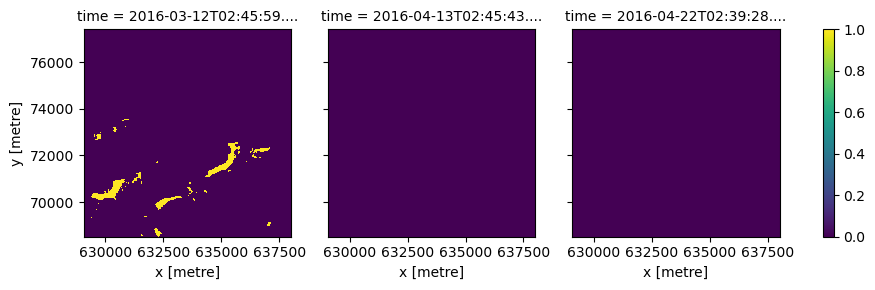

In [18]:
wet.isel(time=[0,1,2]).plot.imshow(col='time');

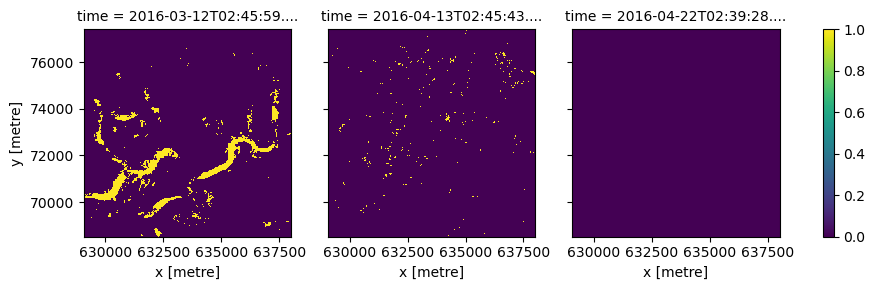

In [19]:
# above is different to water_observed which means the wofs classifier has returned a positive detection but the classification may be incorrect
water_observed = make_mask(wofs_masked, water_observed=True)
water_observed.isel(time=[0,1,2]).plot.imshow(col='time');

> Can you identify what caused potentially incorrect water classifications?

## Inundation frequency

With information on both water detection and clear observations, we can now calculate how frequent water is detected in each pixel.

In [20]:
# first we find all clear pixels
dry = make_mask(wofs_masked, dry=True)
clear = wet + dry

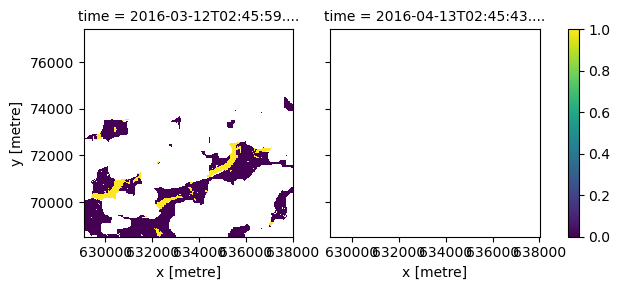

In [21]:
# clear pixels can be used as a mask
wet.where(clear).isel(time=[0,1]).plot.imshow(col='time');

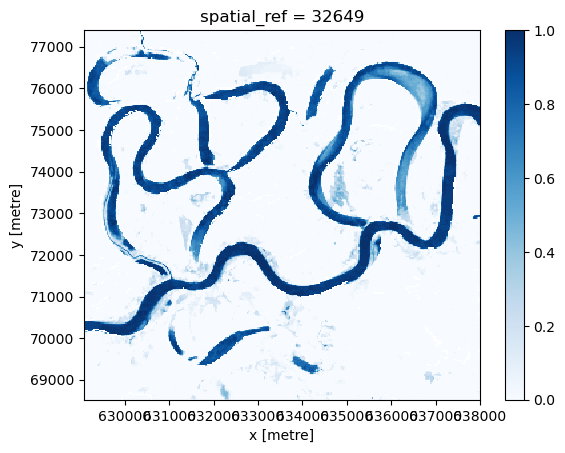

In [22]:
# now calculate and plot water detection frequency with only clear observations included in the calculation
freq = wet.where(clear).mean(dim='time')
freq.plot.imshow(cmap='Blues');

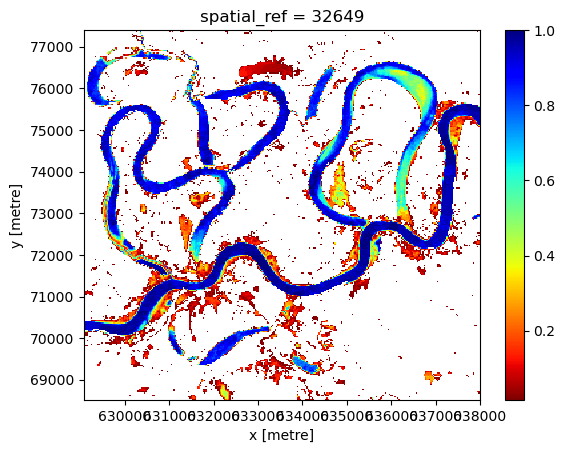

In [26]:
# a prettier color map but not monotonic
freq.where(freq>0).plot.imshow(cmap='jet_r');

## Further exploration

* Is the pattern of inundation frequency consistent with what's known on the ground?

* Would the picture change when the analysis period is extended?

* Are there other areas where this analysis could be applied?

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 